In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('F.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-28,14.78,15.00,14.67,14.97,11.841009,34485300
1,2015-10-29,14.94,14.96,14.61,14.73,11.651173,32247000
2,2015-10-30,14.74,14.95,14.63,14.81,11.714453,29225800
3,2015-11-02,14.79,14.90,14.71,14.75,11.666993,30295900
4,2015-11-03,14.78,14.87,14.72,14.81,11.714453,25878800


In [3]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [4]:
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2015-10-28', '2015-10-29', '2015-10-30', '2015-11-02',
               '2015-11-03', '2015-11-04', '2015-11-05', '2015-11-06',
               '2015-11-09', '2015-11-10',
               ...
               '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-19',
               '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23',
               '2020-10-26', '2020-10-27'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [5]:
# adding columns month, year, and day for a groupby

df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df.head()

,Open,High,Low,Close,Adj Close,Volume,year,month,day
Date,,,,,,,,,
2015-10-28,14.78,15.00,14.67,14.97,11.841009,34485300,2015,10,28
2015-10-29,14.94,14.96,14.61,14.73,11.651173,32247000,2015,10,29
2015-10-30,14.74,14.95,14.63,14.81,11.714453,29225800,2015,10,30
2015-11-02,14.79,14.90,14.71,14.75,11.666993,30295900,2015,11,2
2015-11-03,14.78,14.87,14.72,14.81,11.714453,25878800,2015,11,3


In [6]:
# Lets get a random sample of 10
df.sample(10, random_state=0)

,Open,High,Low,Close,Adj Close,Volume,year,month,day
Date,,,,,,,,,
2015-11-04,14.83,14.86,14.64,14.65,11.587894,27166400,2015,11,4
2017-10-13,12.06,12.17,11.87,12.05,10.373618,44597300,2017,10,13
2016-01-13,12.73,12.84,12.06,12.20,9.649986,102174700,2016,1,13
2019-09-30,9.11,9.21,9.10,9.16,8.861395,21510000,2019,9,30
2016-07-26,13.73,13.88,13.69,13.86,11.344265,28467200,2016,7,26
2015-11-23,14.60,14.73,14.51,14.55,11.508797,18273900,2015,11,23
2017-02-01,12.45,12.58,12.22,12.32,10.332325,44396800,2017,2,1
2017-11-07,12.35,12.38,12.11,12.16,10.598303,41536300,2017,11,7
2017-04-10,11.26,11.35,11.24,11.25,9.434956,25857100,2017,4,10


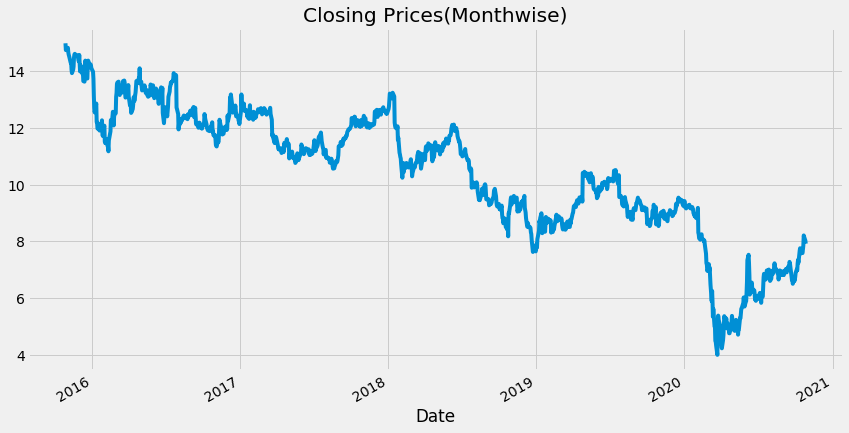

In [7]:
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(13,7), title= 'Closing Prices(Monthwise)')

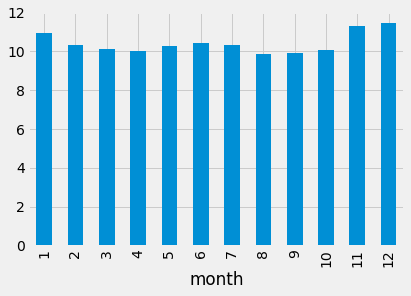

In [8]:
df.groupby('month')['Close'].mean().plot.bar()

In [9]:
test = df[1029:]
train = df[:1028]

In [10]:
def test_stationarity(timeseries):
    plt.figure(figsize=(13,7))
     #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
     #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print('Results of dickey fuller test')
    adft = adfuller(timeseries,autolag='AIC')
     # output for adft will give us without defining what the values are.
     #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)


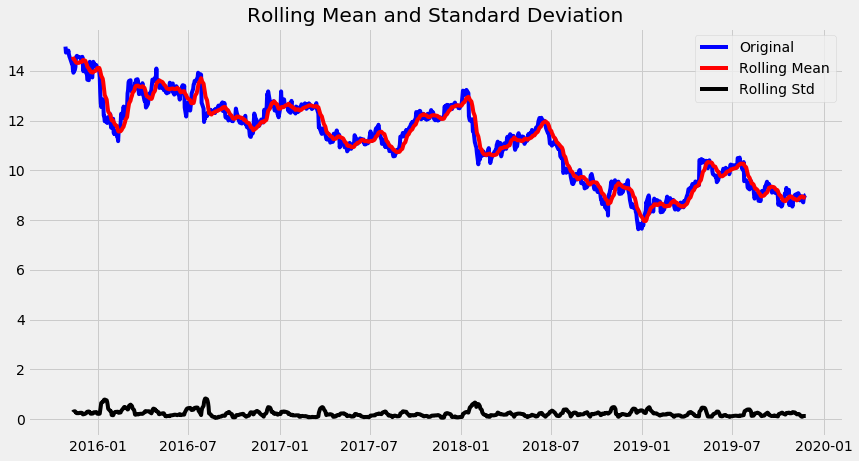

Results of dickey fuller test
Test Statistics                  -2.236356
p-value                           0.193316
No. of lags used                  0.000000
Number of observations used    1027.000000
critical value (1%)              -3.436733
critical value (5%)              -2.864358
critical value (10%)             -2.568271
dtype: float64


In [11]:
test_stationarity(train['Close'])

### Data is not stationary, will need to make it stationary

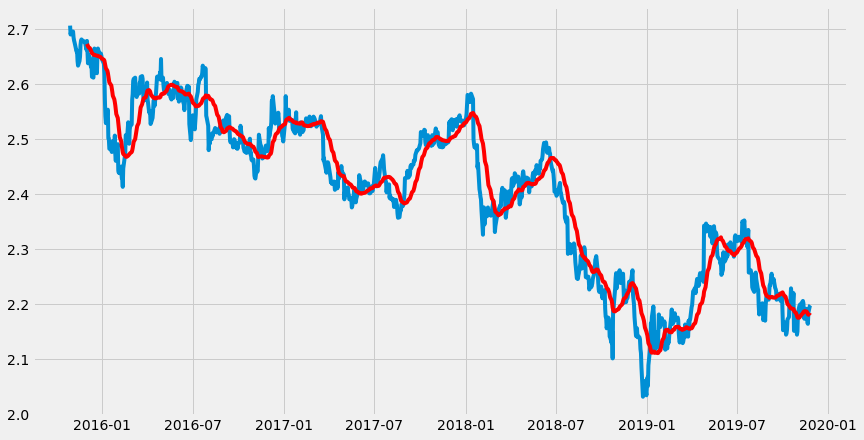

In [12]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])
moving_avg = train_log.rolling(24).mean() 
plt.figure(figsize=(13,7))
plt.plot(train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()


In [13]:
train_log_moving_avg_diff = train_log - moving_avg

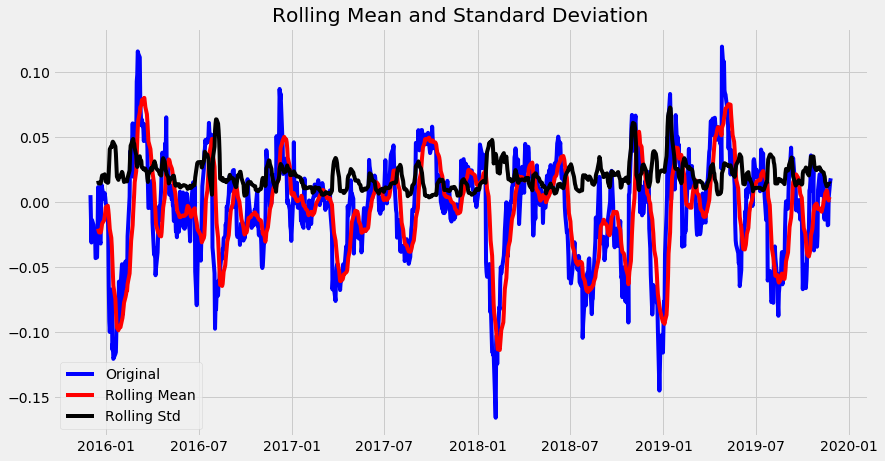

Results of dickey fuller test
Test Statistics               -6.690473e+00
p-value                        4.121893e-09
No. of lags used               4.000000e+00
Number of observations used    1.000000e+03
critical value (1%)           -3.436906e+00
critical value (5%)           -2.864435e+00
critical value (10%)          -2.568311e+00
dtype: float64


(None, None)

In [14]:
train_log_moving_avg_diff.dropna(inplace = True), test_stationarity(train_log_moving_avg_diff)

### Trend is removed... Test Statistic < Critical Value and P-Value < 5%

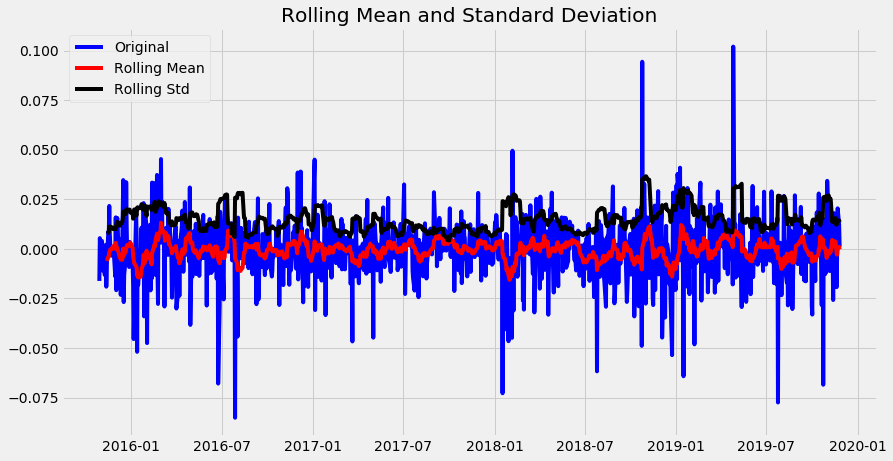

Results of dickey fuller test
Test Statistics                 -33.543684
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    1026.000000
critical value (1%)              -3.436740
critical value (5%)              -2.864361
critical value (10%)             -2.568272
dtype: float64


In [15]:
train_log_diff = train_log - train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

### Eliminating the trend further

### Time to remove seasonality (skipping)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5579.749, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5585.114, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5585.347, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5585.306, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5586.124, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5583.434, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.055 seconds


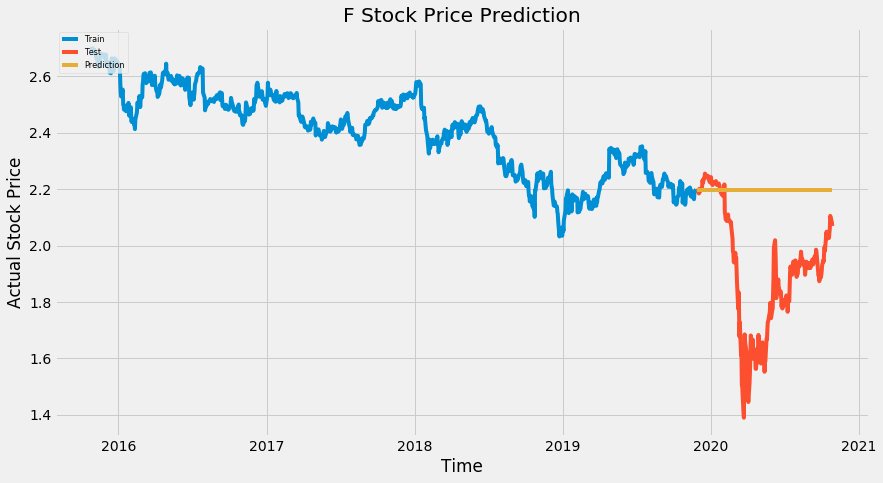

In [21]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_log)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test_log.index,columns=['Prediction'])
plt.figure(figsize=(13,7))
#plot the predictions for validation set
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('F Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## No one anticipated the CCP virus. This is understandable.

In [22]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test_log,forecast))
print("RMSE: ", rms)

RMSE:  0.3565034618154012


## RMSE isnt too bad, but Id much rather it be closer to zero.